In [1]:
from tqdm.notebook import tqdm
from functools import partial

import jax
from jax import numpy as jnp
import numpy as np

from dart import dataset, sample

2022-12-08 21:31:46.640438: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-12-08 21:31:46.640500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-12-08 21:31:46.640504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
res = 96
rmin, rmax = 0, 10
dmin, dmax = -5, 5
theta_lim = jnp.pi / 12
phi_lim = jnp.pi / 3

sensor = sample.VirtualRadar(
    r=jnp.linspace(rmin, rmax, res), d=jnp.linspace(dmin, dmax, res),
    theta_lim=theta_lim, phi_lim=phi_lim, n=360, k=120)

gt = dataset.gt_map("data/map.mat")
traj = dataset.trajectory("data/traj.mat", sensor=sensor)

render = partial(sensor.render, key=jax.random.PRNGKey(42), sigma=gt)
render = jax.jit(jax.vmap(render))

In [3]:
frames = []

for batch in tqdm(traj.batch(64)):
    pose = jax.tree_util.tree_map(jnp.array, batch)
    frames.append(np.asarray(render(pose=pose)))

frames = np.concatenate(frames, axis=0)
np.savez_compressed(
    "data/sim_{}_occ.npz".format(res), y=frames,
    extents=np.array([dmin, dmax, rmin, rmax]))

  0%|          | 0/157 [00:00<?, ?it/s]

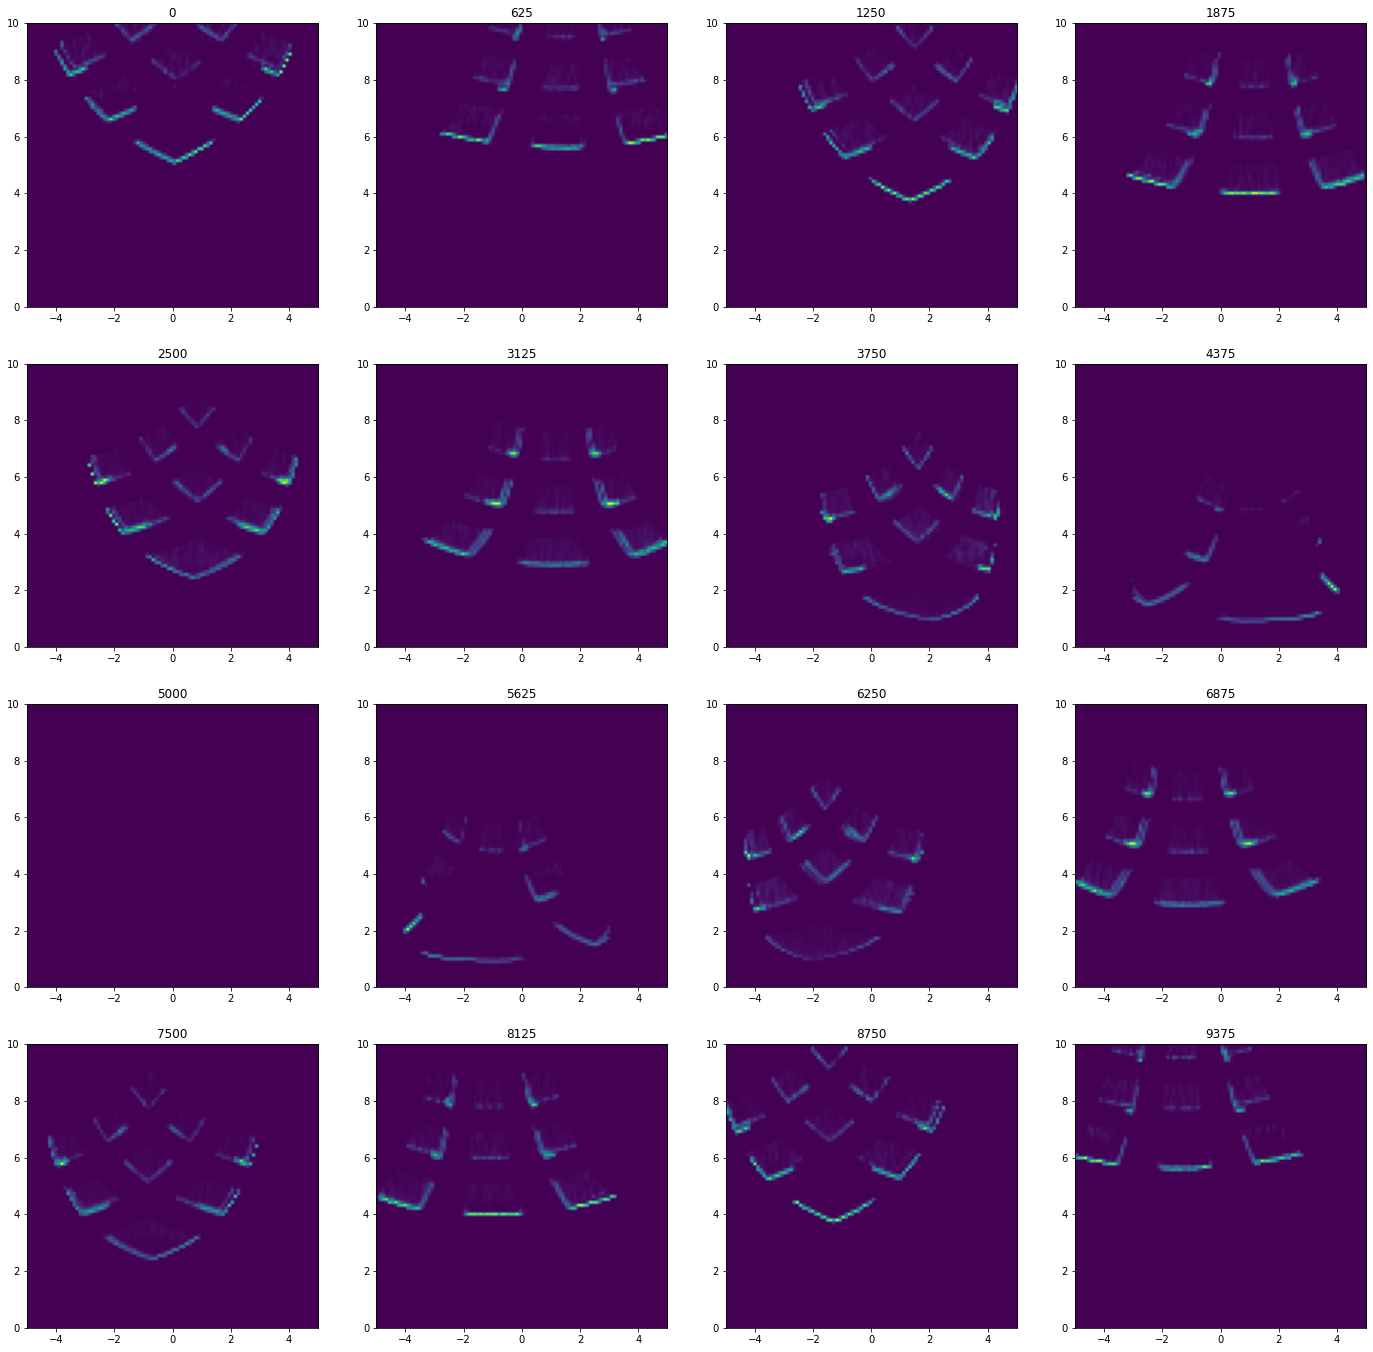

In [4]:
import numpy as np
from matplotlib import pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(24, 24))
axs = axs.reshape(-1)

y = np.load("data/sim_{}_occ.npz".format(res))
t = (np.arange(axs.shape[0]) * y['y'].shape[0] / axs.shape[0]).astype(int)
for i, ax in zip(t, axs):
    ax.imshow(y['y'][i], extent=y['extents'], aspect='auto', origin='lower')
    ax.set_title(i)